In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle




%matplotlib inline

In [18]:
# Membaca file CSV dan mengimpor kolom tertentu
data = pd.read_csv('dataset_tweet_sentiment_cellular_service_provider.csv')
data = data.rename(columns={'Text Tweet': 'text','Sentiment':'sentiment'})

# Menampilkan data
data

,Id,sentiment,text
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>
...,...,...,...
295,296,positive,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yan..."
296,297,positive,Alhamdulillah lancar pakai <PROVIDER_NAME>
297,298,positive,"Untung pakai internet <PROVIDER_NAME>, lancar,..."
298,299,positive,"di tempat ramai seperti di lokasi wisata, <PRO..."


In [19]:
data = data.drop(['Id'], axis = 1)
data.isnull().sum()

sentiment    0
text         0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

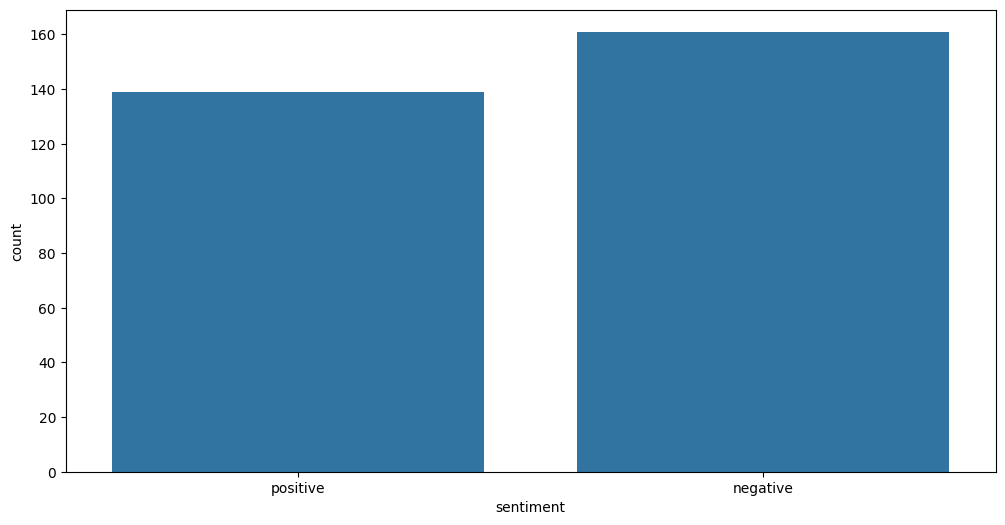

In [20]:

plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=data)

# Case Folding

In [39]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
    text = text.lower()   # Mengubah teks menjadi lower case    
    text = re.sub(r'#\w+\s*', ' ', text)
    text = re.sub(r'<[^>]+>|\n', ' ', text)            # Menghapus <...>                      
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text) # Menghapus URL
    text = re.sub(r'[-+]?[0-9]+', ' ', text)           # Menghapus angka
    text = re.sub(r'[^\w\s]', ' ', text)               # Menghapus karakter tanda baca
    return text

In [40]:
raw_sample = data['text'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Untuk penembakan paket dari <PRODUCT_NAME> masih gangguan ya <PROVIDER_NAME>
Case folding	:  untuk penembakan paket dari   masih gangguan ya  


## Word Normalization

In [41]:
key_norm = pd.read_csv('key_norm_indo.csv')

selected_columns = key_norm[['singkat', 'hasil']]

key_norm = pd.DataFrame(selected_columns)

print(key_norm.head())

key_norm.shape

       singkat       hasil
0         abis       habis
1       accent     tekanan
2       accept      terima
3     accident  kecelakaan
4  achievement    prestasi


(18727, 2)

In [42]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [43]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [44]:
len(stopwords_ind)

758

In [45]:
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [46]:
def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [47]:
raw_sample = data['text'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Untuk penembakan paket dari <PRODUCT_NAME> masih gangguan ya <PROVIDER_NAME>
Case folding		:  untuk penembakan paket dari   masih gangguan ya  
Stopword removal	:  penembakan paket gangguan ya


## Stemming

In [48]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [49]:
raw_sample = data['text'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Untuk penembakan paket dari <PRODUCT_NAME> masih gangguan ya <PROVIDER_NAME>
Case folding		:  untuk penembakan paket dari   masih gangguan ya  
Stopword removal	:  penembakan paket gangguan ya
Stemming		:  tembak paket ganggu ya


## Text Preprocessing Pipeline

In [50]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [51]:
%%time
data['clean_teks'] = data['text'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: total: 24.6 s
Wall time: 24.6 s


In [52]:
data

,sentiment,text,clean_teks
0,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,produk bangsa
1,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",sakti alhamdulillah v
2,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi bantu kamar sinyal hilang panggil...
3,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear jaring data lot banget h
4,negative,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam dusta
...,...,...,...
295,positive,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yan...",pantesan lancar ya sinyal lancar lombok timur
296,positive,Alhamdulillah lancar pakai <PROVIDER_NAME>,alhamdulillah lancar pakai
297,positive,"Untung pakai internet <PROVIDER_NAME>, lancar,...",untung pakai internet lancar ide
298,positive,"di tempat ramai seperti di lokasi wisata, <PRO...",ramai lokasi wisata jaya


In [53]:
data.to_csv('jaringanClean.csv', index=False)

# simple deployment

In [57]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Mengimpor model dari file .joblib
model = joblib.load('nlpJarinan.joblib')
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [62]:
#@title Masukkan Teks Anda:
input_text = "alhamdulillah internetnya lemot" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)
print('Hasil Prediksi           :', input_text, '\n\n', result)

Hasil Text Preprocessing : alhamdulillah internetnya lot
Hasil Prediksi           : alhamdulillah internetnya lemot 

 ['negative']
